## Kolmogorov

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.stats import ks_2samp

Base = pd.read_csv("/content/drive/MyDrive/Bayesiana/breast-cancer.csv")

Base = Base.drop(columns=["id"], errors="ignore")

Base["diagnosis_numeric"] = Base["diagnosis"].apply(lambda x: 1 if x == "M" else 0)

resultados = pd.DataFrame(columns=["Variable", "PValor"])

for variable in Base.select_dtypes(include=["float64", "int64"]).columns:
    if variable != "diagnosis_numeric":
      muestra1 = Base.query("diagnosis_numeric == 1")[variable]
      muestra2 = Base.query("diagnosis_numeric == 0")[variable]
      resultado = ks_2samp(muestra1, muestra2)
      resultados = pd.concat([
          resultados,
          pd.DataFrame({"Variable": [variable], "PValor": [resultado.pvalue], "Decision": ["Si" if resultado.pvalue<0.05 else "No"]})
        ], ignore_index=True)

print(resultados)


<ipython-input-6-0d8577fcdc5b>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([


                   Variable        PValor Decision
0               radius_mean  3.382295e-69       Si
1              texture_mean  2.420681e-27       Si
2            perimeter_mean  1.072860e-75       Si
3                 area_mean  7.890178e-71       Si
4           smoothness_mean  1.697694e-14       Si
5          compactness_mean  2.630518e-46       Si
6            concavity_mean  1.522731e-76       Si
7       concave points_mean  1.959605e-93       Si
8             symmetry_mean  8.593290e-12       Si
9    fractal_dimension_mean  1.903756e-02       Si
10                radius_se  1.859274e-47       Si
11               texture_se  1.350270e-01       No
12             perimeter_se  6.732940e-48       Si
13                  area_se  5.412699e-70       Si
14            smoothness_se  2.339449e-01       No
15           compactness_se  1.083778e-18       Si
16             concavity_se  4.331441e-31       Si
17        concave points_se  3.484990e-27       Si
18              symmetry_se  3.

## Random Forest

Matriz de confusión:
[[107   1]
 [  3  60]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       108
           1       0.98      0.95      0.97        63

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



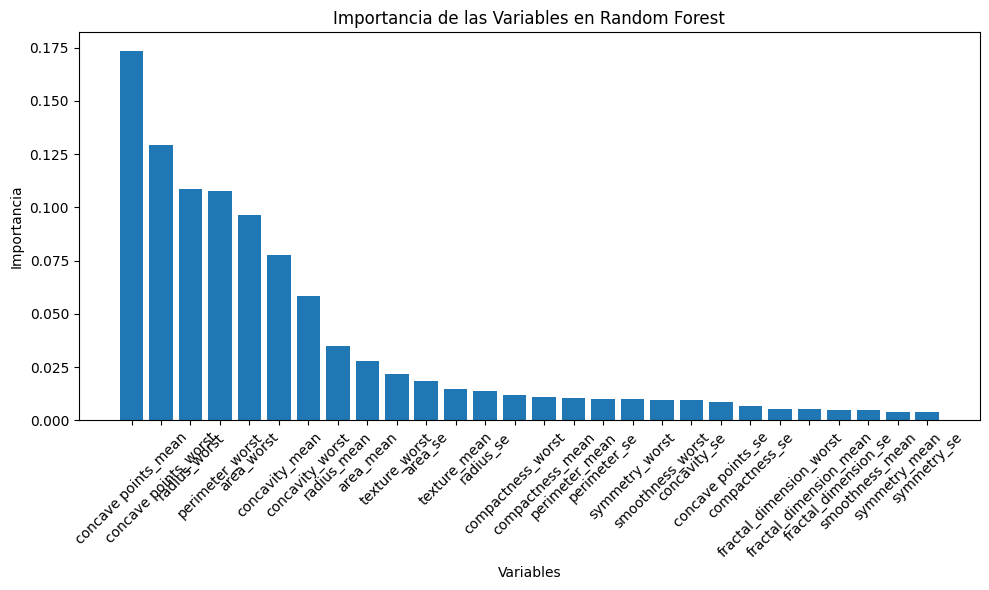

                   Variable  Importancia
7       concave points_mean     0.173541
25     concave points_worst     0.129155
18             radius_worst     0.108862
20          perimeter_worst     0.107718
21               area_worst     0.096541
6            concavity_mean     0.077686
24          concavity_worst     0.058611
0               radius_mean     0.034805
3                 area_mean     0.027803
19            texture_worst     0.021691
12                  area_se     0.018448
1              texture_mean     0.014943
10                radius_se     0.013769
23        compactness_worst     0.011840
5          compactness_mean     0.010966
2            perimeter_mean     0.010319
11             perimeter_se     0.010221
26           symmetry_worst     0.009897
22         smoothness_worst     0.009719
14             concavity_se     0.009622
15        concave points_se     0.008831
13           compactness_se     0.006840
27  fractal_dimension_worst     0.005379
9    fractal_dim

In [ ]:
# Filtrar variables significativas
significativas = resultados.query("Decision == 'Si'")["Variable"].tolist()

# Preparar datos para Random Forest
X = Base[significativas]
y = Base["diagnosis_numeric"]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Importancia de las variables
importancias = rf.feature_importances_
importancia_df = pd.DataFrame({"Variable": significativas, "Importancia": importancias})
importancia_df = importancia_df.sort_values(by="Importancia", ascending=False)

# Visualizar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.bar(importancia_df["Variable"], importancia_df["Importancia"])
plt.title("Importancia de las Variables en Random Forest")
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(importancia_df)

In [ ]:
top_10_variables = importancia_df.head(10)["Variable"].tolist()

nuevo_dataframe = Base[["diagnosis"] + top_10_variables]

# Mostrar el nuevo DataFrame
print(nuevo_dataframe.head())


  diagnosis  concave points_mean  concave points_worst  radius_worst  \
0         M              0.14710                0.2654         25.38   
1         M              0.07017                0.1860         24.99   
2         M              0.12790                0.2430         23.57   
3         M              0.10520                0.2575         14.91   
4         M              0.10430                0.1625         22.54   

   perimeter_worst  area_worst  concavity_mean  concavity_worst  radius_mean  \
0           184.60      2019.0          0.3001           0.7119        17.99   
1           158.80      1956.0          0.0869           0.2416        20.57   
2           152.50      1709.0          0.1974           0.4504        19.69   
3            98.87       567.7          0.2414           0.6869        11.42   
4           152.20      1575.0          0.1980           0.4000        20.29   

   area_mean  texture_worst  
0     1001.0          17.33  
1     1326.0          23.4

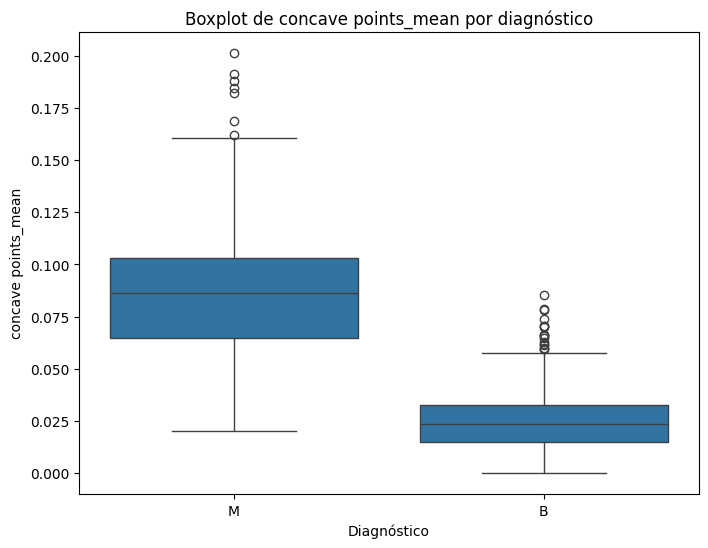

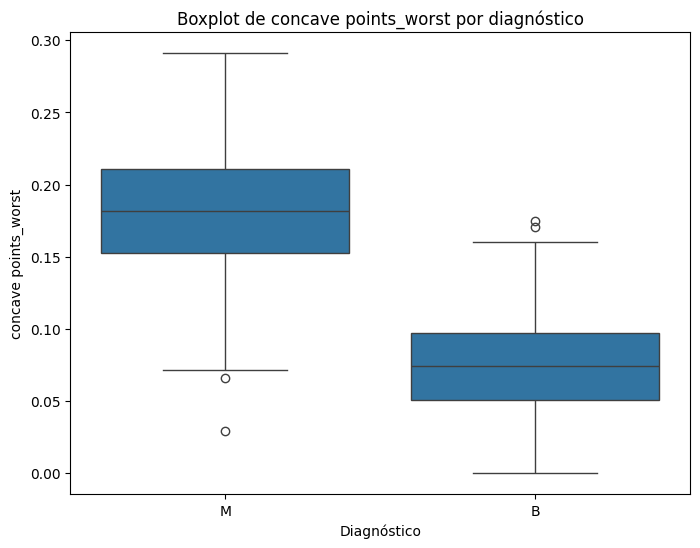

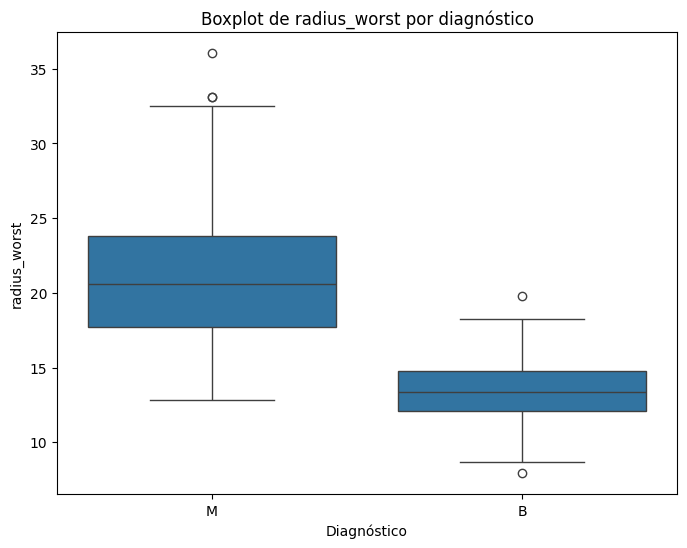

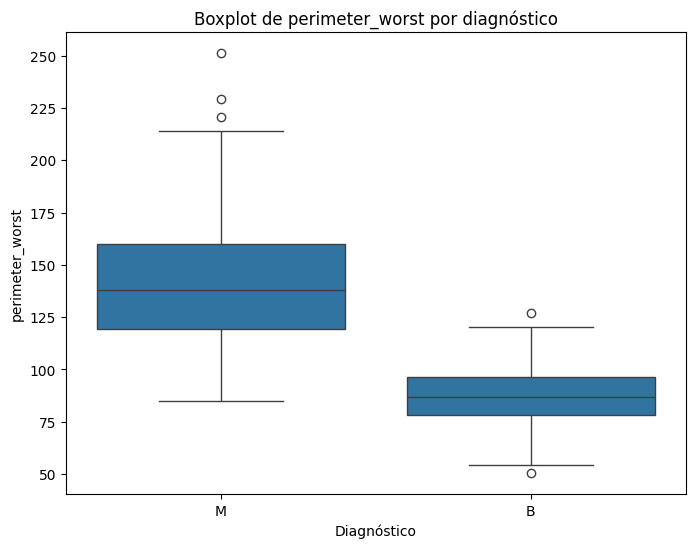

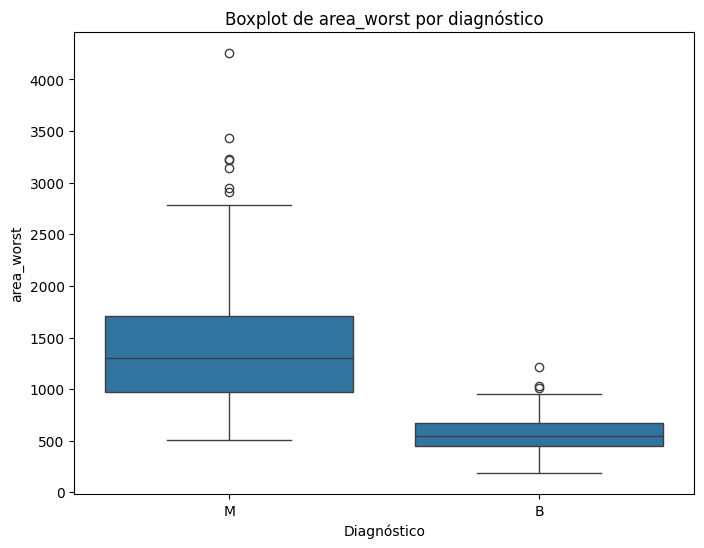

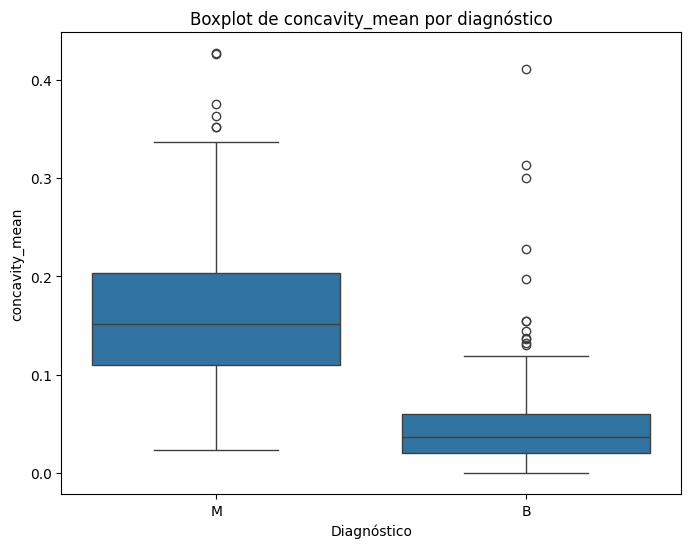

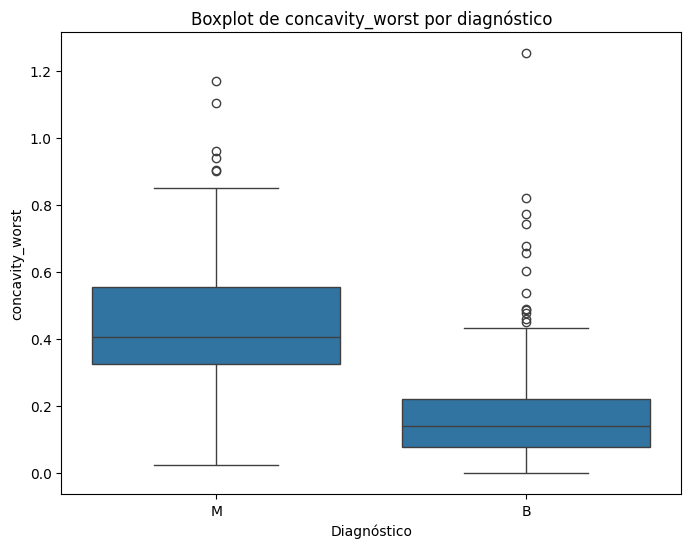

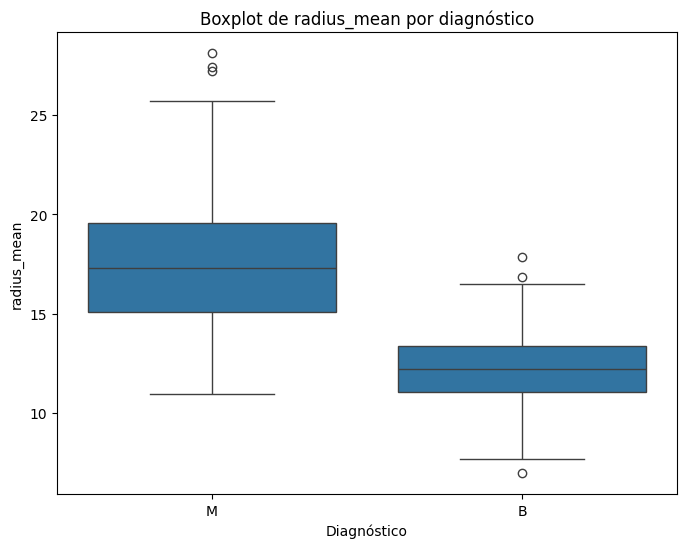

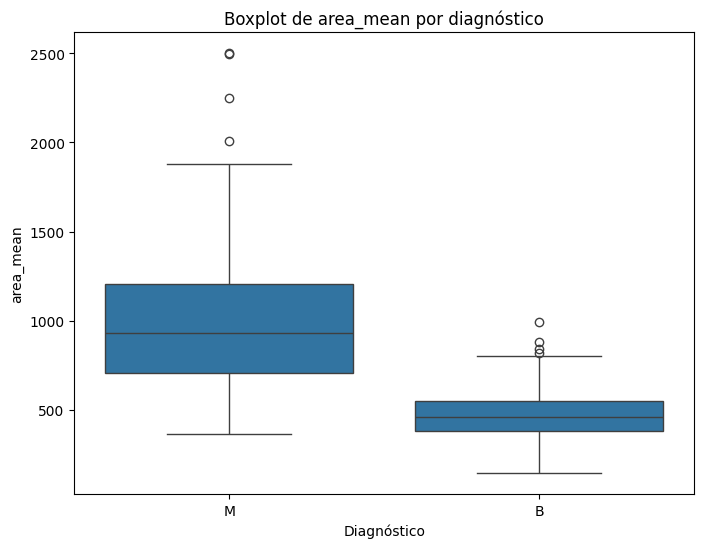

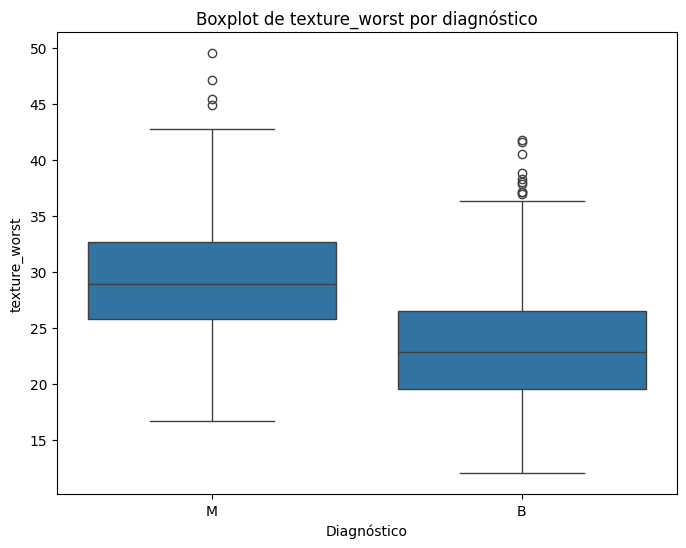

In [ ]:
for variable in top_10_variables:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="diagnosis", y=variable, data=nuevo_dataframe)
    plt.title(f"Boxplot de {variable} por diagnóstico")
    plt.xlabel("Diagnóstico")
    plt.ylabel(variable)
    plt.show()

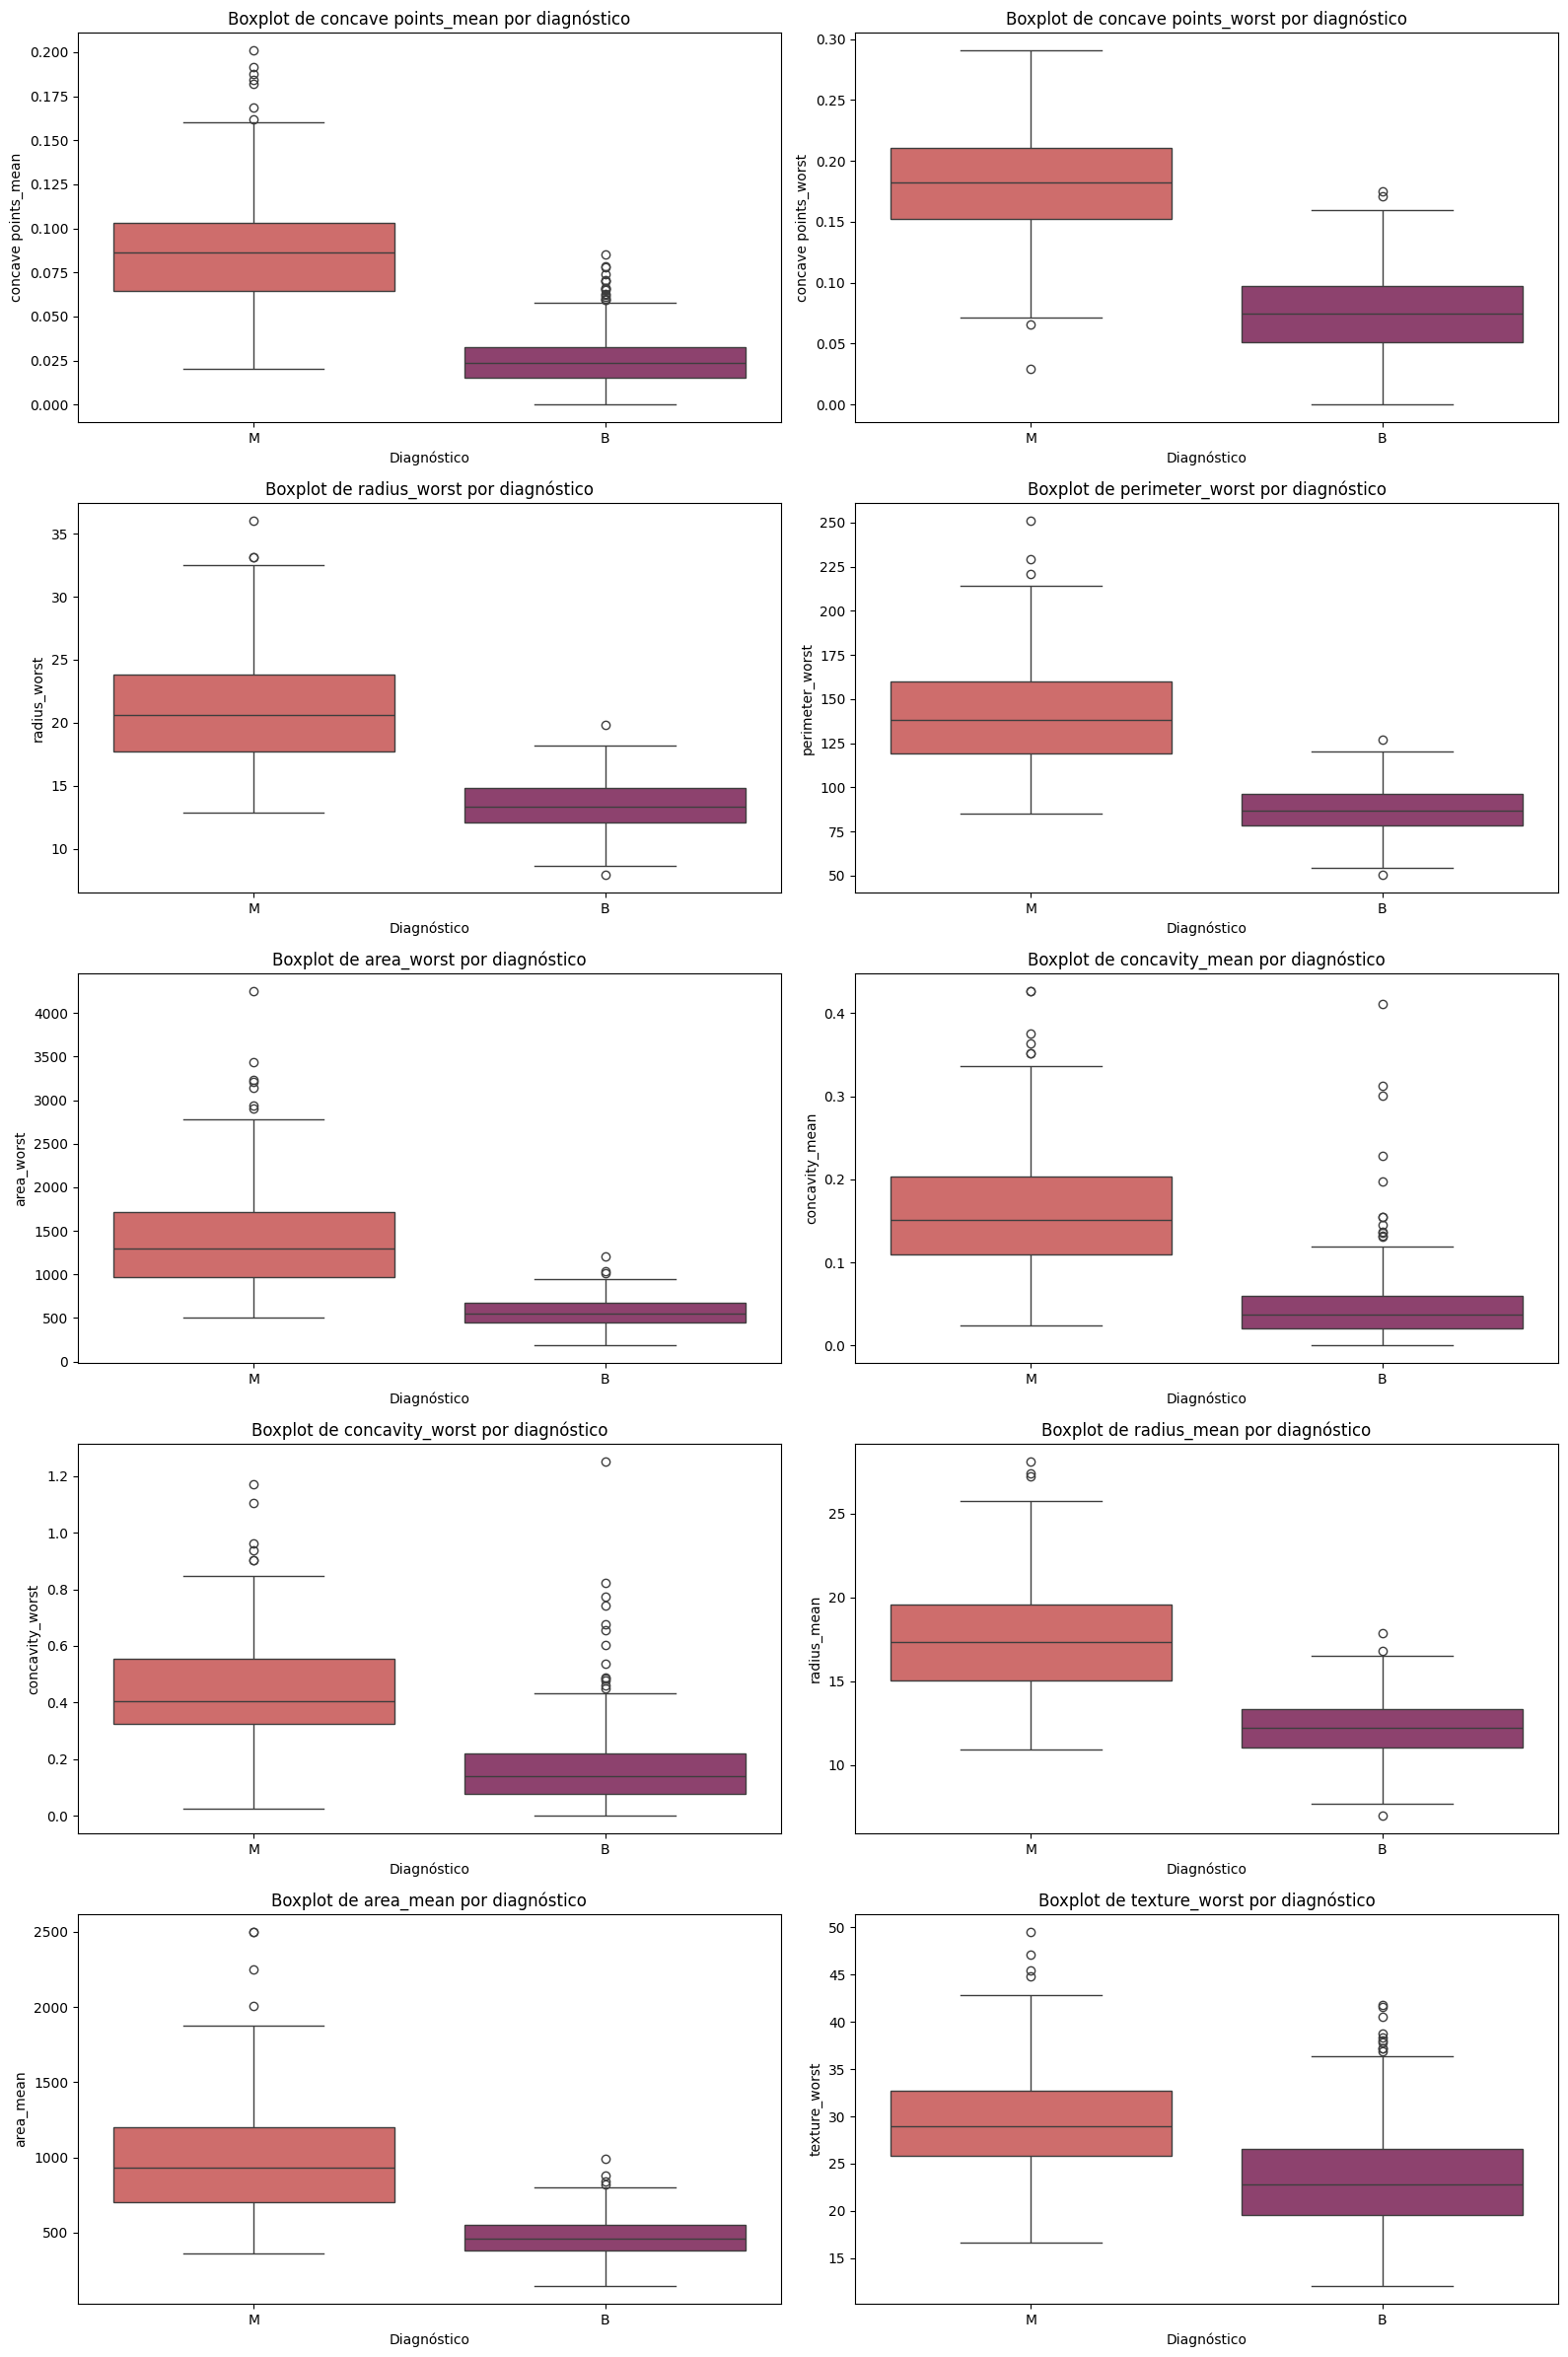

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = axes.flatten()

for i, variable in enumerate(top_10_variables):
    sns.boxplot(data=nuevo_dataframe, x="diagnosis", y=variable, hue="diagnosis",
                palette="flare", ax=axes[i])
    axes[i].set_title(f"Boxplot de {variable} por diagnóstico")
    axes[i].set_xlabel("Diagnóstico")
    axes[i].set_ylabel(variable)

plt.tight_layout()
plt.show()

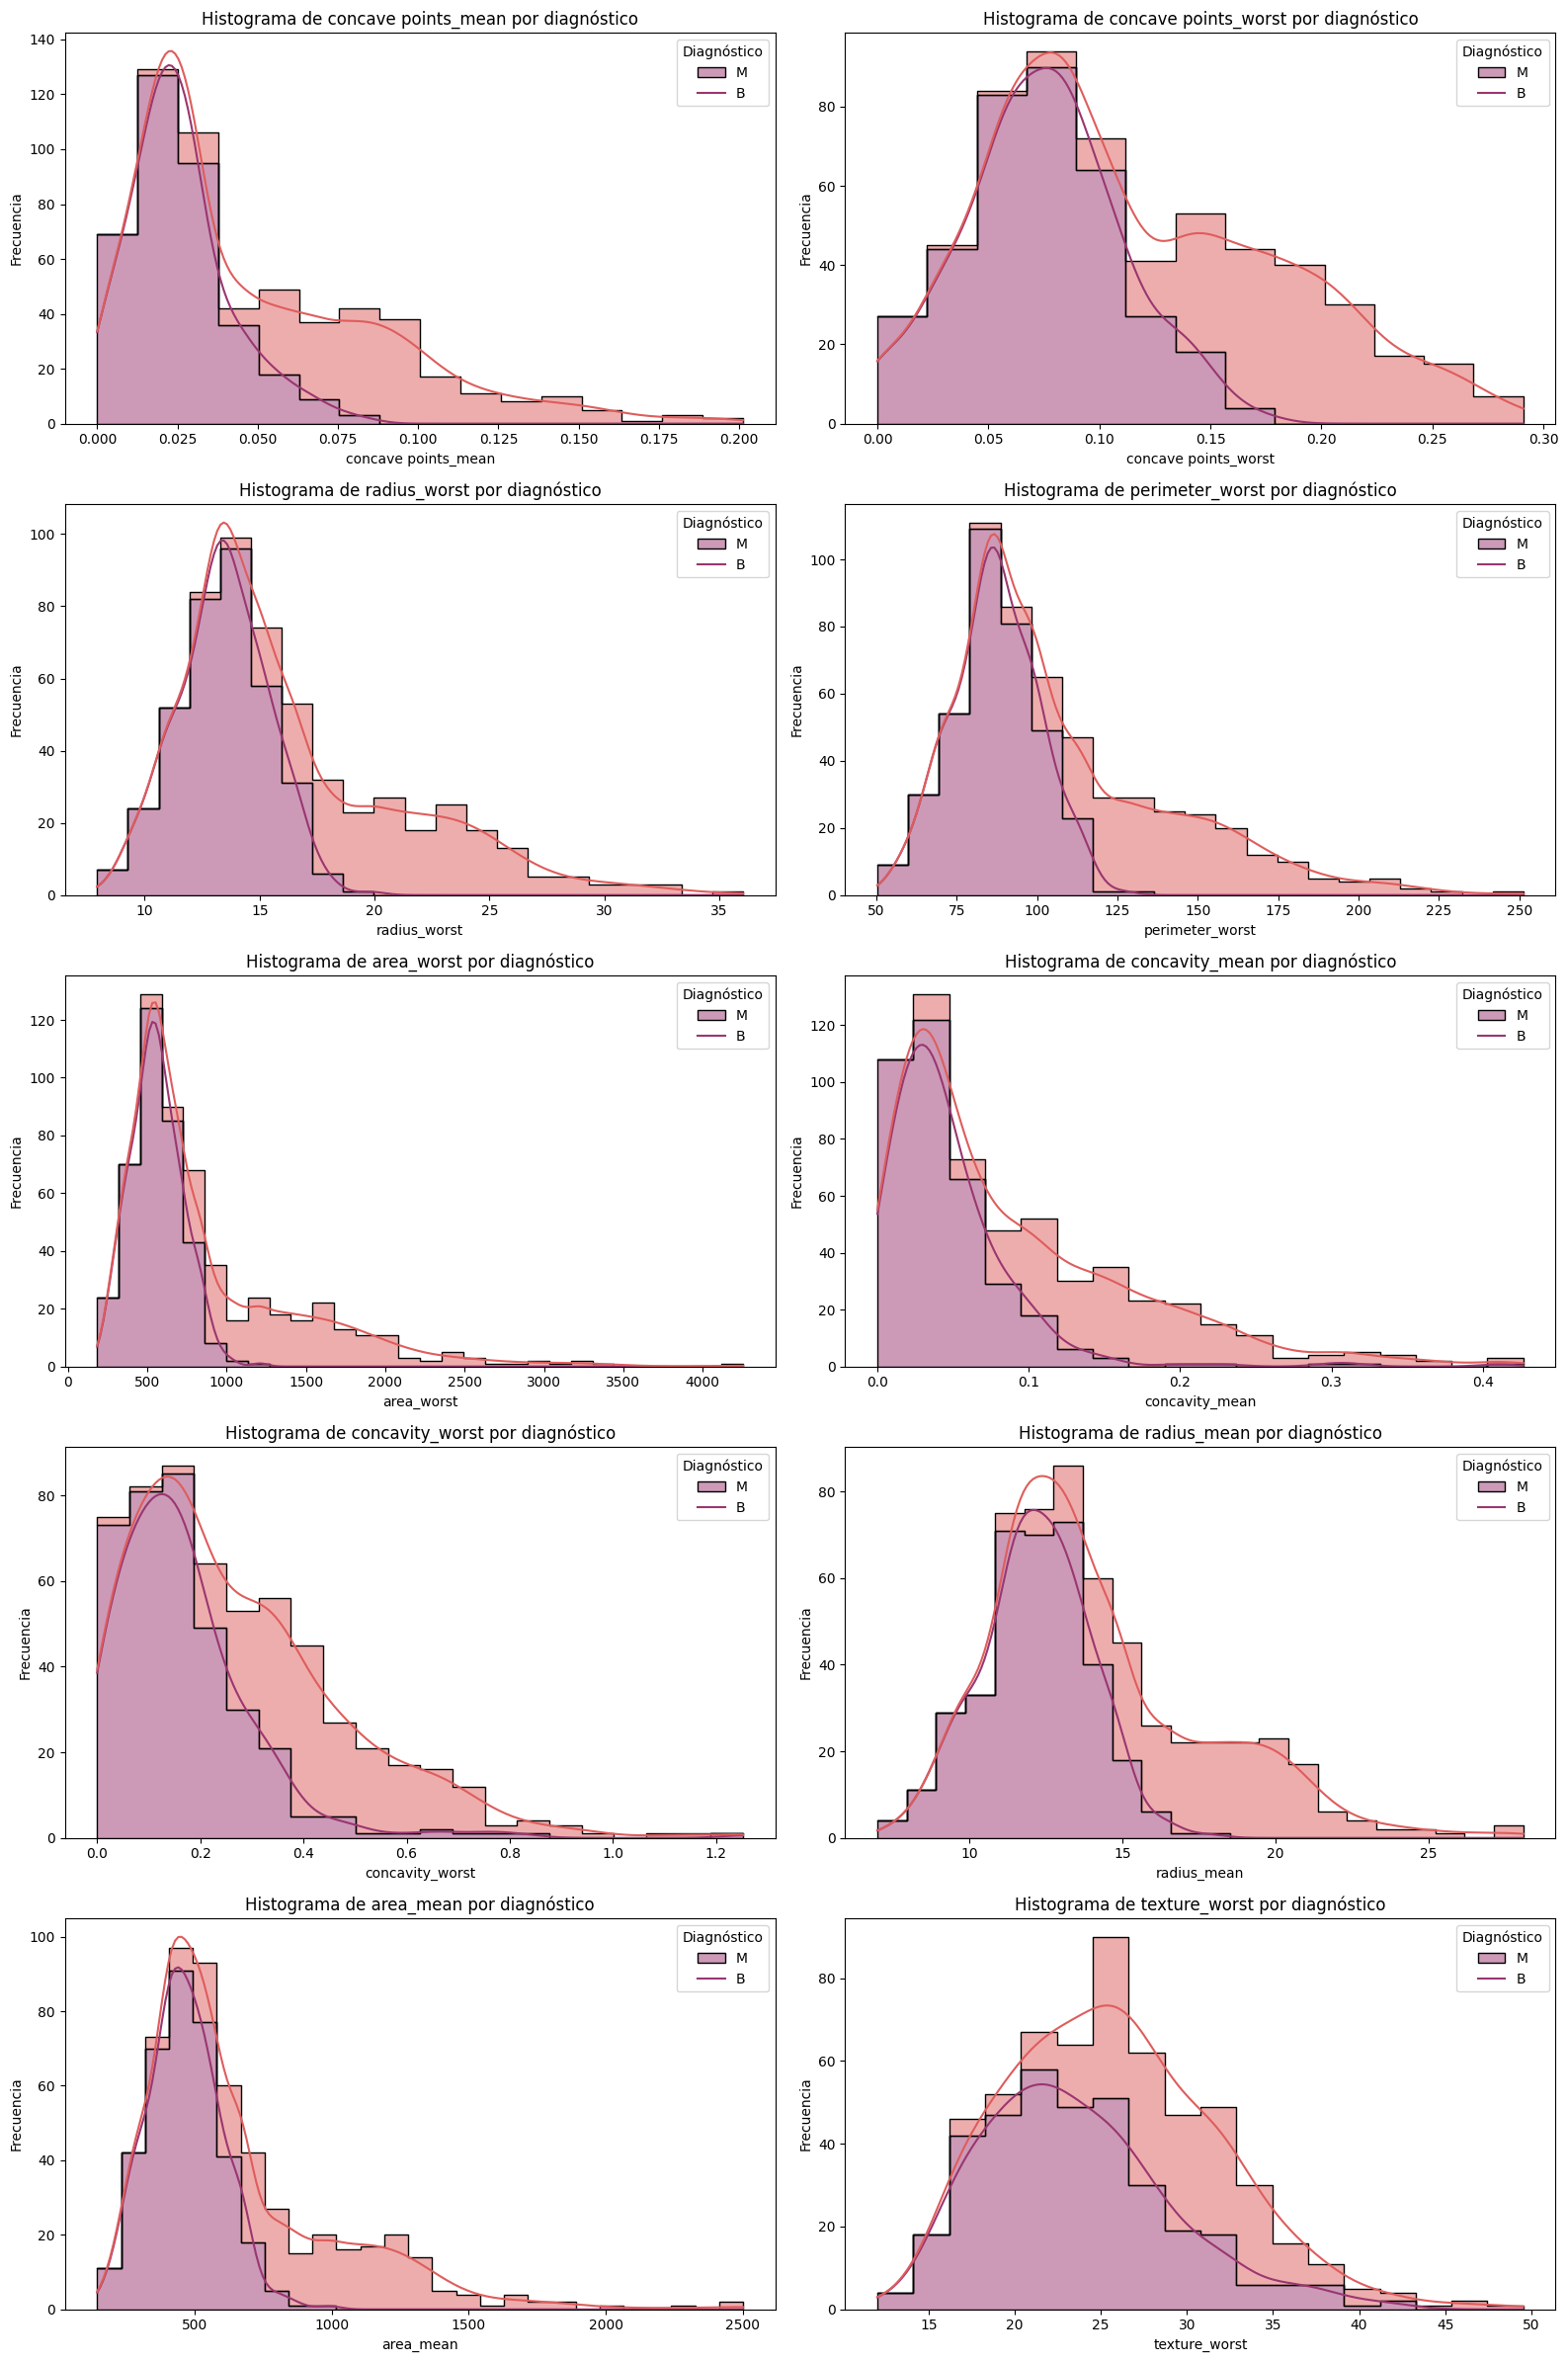

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = axes.flatten()

for i, variable in enumerate(top_10_variables):
    sns.histplot(data=nuevo_dataframe, x=variable, kde=True, hue="diagnosis",
                 element="step", multiple="stack", palette="flare", ax=axes[i])
    axes[i].set_title(f"Histograma de {variable} por diagnóstico")
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel("Frecuencia")
    axes[i].legend(title="Diagnóstico", labels=nuevo_dataframe["diagnosis"].unique())

plt.tight_layout()
plt.show()


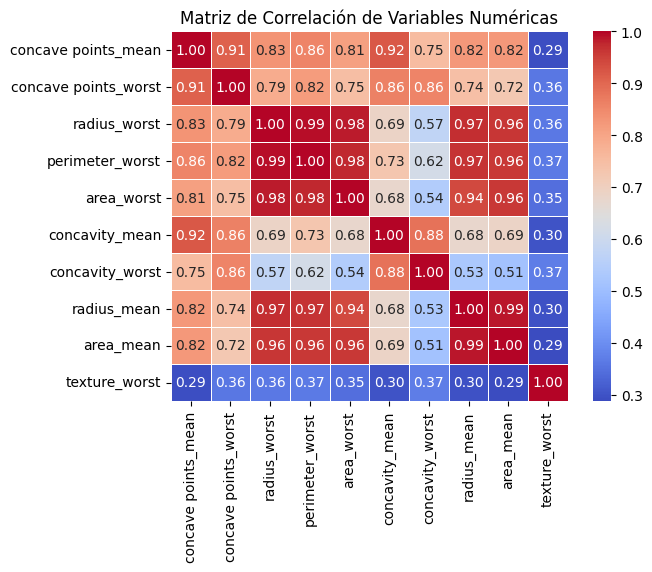

In [ ]:

numericas = nuevo_dataframe.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = nuevo_dataframe[numericas].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

# Modelos


In [ ]:
import os
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from io import StringIO
import pydotplus
from IPython.display import Image, SVG
from sklearn.model_selection import GridSearchCV

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from io import StringIO
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from PIL import Image


In [ ]:
top_10_variables = importancia_df.head(10)["Variable"].tolist()
nuevo_dataframe = Base[["diagnosis"] + top_10_variables]

nuevo_dataframe['diagnosis'] = nuevo_dataframe['diagnosis'].map({'B': 0, 'M': 1})

X = nuevo_dataframe[top_10_variables]
y = nuevo_dataframe['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


<ipython-input-42-7fa9f9978f60>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevo_dataframe['diagnosis'] = nuevo_dataframe['diagnosis'].map({'B': 0, 'M': 1})


Arbol de decision


In [ ]:
clf = DecisionTreeClassifier(max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.05, random_state=42)
clf = clf.fit(X_train, y_train)

X_train_v2 = X_train.copy()
X_train_v2['pscore_tree'] = clf.predict_proba(X_train)[:, 1]


In [ ]:
# Realizar las predicciones de probabilidad para el conjunto de prueba
y_pred_prob_tree = clf.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva (1)

# Imprimir las primeras 10 probabilidades
print("Probabilidades de la clase positiva (1) en el conjunto de prueba:")
print(y_pred_prob_tree[:10])  # Muestra las primeras 10 probabilidades

# Convertir las probabilidades en clases (0 o 1) usando un umbral de 0.5
y_pred_class_tree = [1 if prob > 0.5 else 0 for prob in y_pred_prob_tree]

# Mostrar las primeras 10 predicciones
print("Predicciones binarizadas (clases 0 o 1):")
print(y_pred_class_tree[:10])


Probabilidades de la clase positiva (1) en el conjunto de prueba:
[0.         1.         1.         0.         0.         1.
 1.         1.         0.56410256 0.        ]
Predicciones binarizadas (clases 0 o 1):
[0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


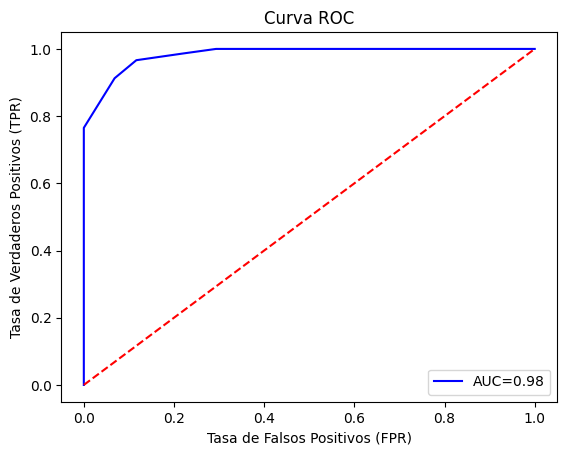

AUC: 0.9831540928815935


In [ ]:
fpr, tpr, threshold = roc_curve(y_train, X_train_v2['pscore_tree'])
auc1 = auc(fpr, tpr)

plt.plot(fpr, tpr, "b-", label="AUC={:.2f}".format(auc1))
plt.plot([0, 1], [0, 1], 'r--')  #
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {auc1}")


In [ ]:
umbrales = pd.DataFrame()
umbrales['Corte'] = threshold
umbrales['FPR'] = fpr
umbrales['TPR'] = tpr
umbrales['Metr'] = abs(umbrales['TPR'] - (1 - umbrales['FPR']))

umbrales = umbrales.sort_values('Metr')
mejor_umbral = umbrales.iloc[0]['Corte']
print(f"Mejor umbral: {mejor_umbral}")

X_train_v2['Default_Tree'] = [1 if x > mejor_umbral else 0 for x in X_train_v2['pscore_tree']]

tn, fp, fn, tp = confusion_matrix(y_train, X_train_v2['Default_Tree']).ravel()

sens = tp / (tp + fn)
espec = tn / (tn + fp)
acc = (tp + tn) / (tn + fp + fn + tp)
prec = tp / (tp + fp)

print(f"La sensibilidad fue: {sens:.2f}")
print(f"La especificidad fue: {espec:.2f}")
print(f"El accuracy del modelo fue: {acc:.2f}")
print(f"La precisión del modelo fue: {prec:.2f}")


Mejor umbral: 0.5641025641025641
La sensibilidad fue: 0.77
La especificidad fue: 1.00
El accuracy del modelo fue: 0.91
La precisión del modelo fue: 1.00


In [ ]:
# Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_train, X_train_v2['Default_Tree']))


              precision    recall  f1-score   support

           0       0.88      1.00      0.93       249
           1       1.00      0.77      0.87       149

    accuracy                           0.91       398
   macro avg       0.94      0.88      0.90       398
weighted avg       0.92      0.91      0.91       398



Matriz de Confusión:
[[249   0]
 [ 35 114]]


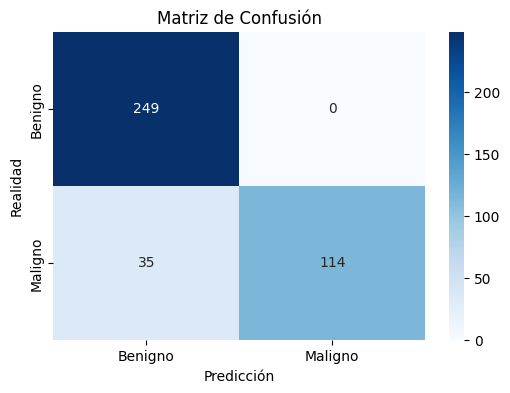

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_train, X_train_v2['Default_Tree']).ravel()

print("Matriz de Confusión:")
print(confusion_matrix(y_train, X_train_v2['Default_Tree']))

conf_matrix = confusion_matrix(y_train, X_train_v2['Default_Tree'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()


# Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nbf = GaussianNB()
nbf.fit(X_train, y_train)

y_pred_prob = nbf.predict_proba(X_test)[:, 1]

print("Probabilidades de la clase positiva (1):")
print(y_pred_prob[:10])


Probabilidades de la clase positiva (1):
[2.37771052e-06 1.00000000e+00 9.99999994e-01 2.07646091e-08
 1.03447865e-09 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.62258230e-01 8.27999286e-08]


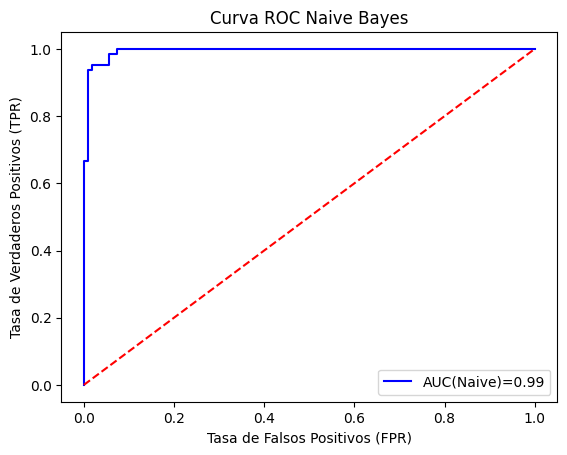

AUC: 0.9942680776014109


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc1 = auc(fpr, tpr)

plt.plot(fpr, tpr, "b-", label="AUC(Naive)={:2.2f}".format(auc1))
plt.plot([0, 1], [0, 1], 'r--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Naive Bayes')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {auc1}")


In [ ]:
import pandas as pd

umbrales = pd.DataFrame()
umbrales['Corte'] = threshold
umbrales['FPR'] = fpr
umbrales['TPR'] = tpr
umbrales['Metr'] = abs(umbrales['TPR'] - (1 - umbrales['FPR']))

umbrales_sorted = umbrales.sort_values('Metr')
mejor_umbral = umbrales_sorted.iloc[0]['Corte']

print(f"Mejor umbral: {mejor_umbral}")

y_pred_class = [1 if x > mejor_umbral else 0 for x in y_pred_prob]

print("Predicciones binarizadas:")
print(y_pred_class[:10])


Mejor umbral: 0.03231861898883732
Predicciones binarizadas:
[0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

sens = tp / (tp + fn)  # Sensibilidad
espec = tn / (tn + fp)  # Especificidad
acc = (tp + tn) / (tn + fp + fn + tp)  # Accuracy
prec = tp / (tp + fp)  # Precisión

# Mostrar las métricas
print(f"La sensibilidad fue: {sens:.2f}")
print(f"La especificidad fue: {espec:.2f}")
print(f"El accuracy del modelo fue: {acc:.2f}")
print(f"La precisión del modelo fue: {prec:.2f}")


La sensibilidad fue: 0.95
La especificidad fue: 0.95
El accuracy del modelo fue: 0.95
La precisión del modelo fue: 0.92


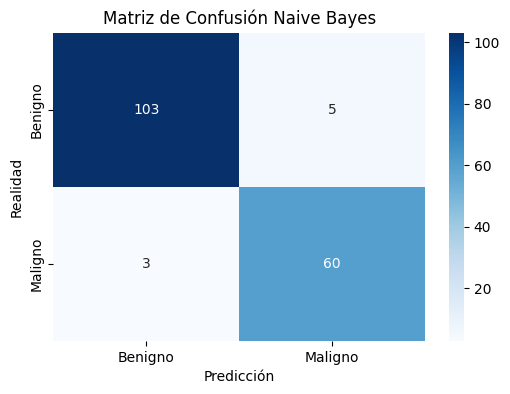

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title("Matriz de Confusión Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()


# Modelo de regresion Logistico

In [ ]:
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo de regresión logística
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predecir las probabilidades para la clase positiva (1) en el conjunto de prueba
y_pred_prob_logit = log_reg.predict_proba(X_test)[:, 1]

# Mostrar las probabilidades predichas para la clase positiva
print("Probabilidades de la clase positiva (1) en el conjunto de prueba:")
print(y_pred_prob_logit[:10])  # Muestra las primeras 10 probabilidades


Probabilidades de la clase positiva (1) en el conjunto de prueba:
[0.17155562 0.99999986 0.99391543 0.00857449 0.00214016 0.99999999
 1.         0.94199144 0.01676803 0.036851  ]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


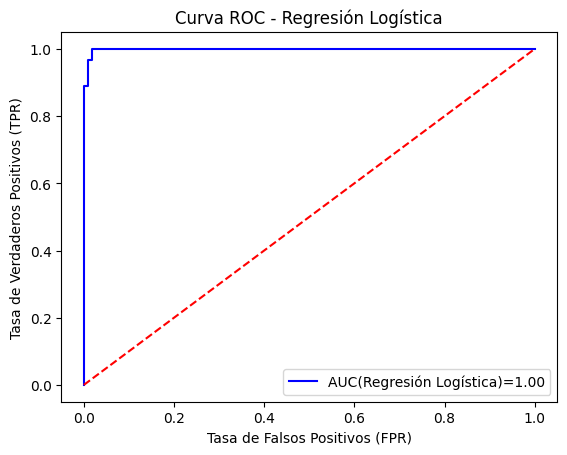

AUC: 0.9986772486772487


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC y AUC
fpr_logit, tpr_logit, threshold_logit = roc_curve(y_test, y_pred_prob_logit)
auc_logit = auc(fpr_logit, tpr_logit)

# Graficar la curva ROC
plt.plot(fpr_logit, tpr_logit, "b-", label="AUC(Regresión Logística)={:2.2f}".format(auc_logit))
plt.plot([0, 1], [0, 1], 'r--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {auc_logit}")


In [ ]:
import pandas as pd

# Crear un DataFrame con los umbrales y métricas
umbrales_logit = pd.DataFrame()
umbrales_logit['Corte'] = threshold_logit
umbrales_logit['FPR'] = fpr_logit
umbrales_logit['TPR'] = tpr_logit
umbrales_logit['Metr'] = abs(umbrales_logit['TPR'] - (1 - umbrales_logit['FPR']))

# Ordenar por la métrica y seleccionar el mejor umbral
umbrales_logit_sorted = umbrales_logit.sort_values('Metr')
mejor_umbral_logit = umbrales_logit_sorted.iloc[0]['Corte']

# Imprimir el mejor umbral
print(f"Mejor umbral de regresión logística: {mejor_umbral_logit}")

# Aplicar el umbral para predecir la clase en el conjunto de prueba
y_pred_class_logit = [1 if x > mejor_umbral_logit else 0 for x in y_pred_prob_logit]

# Mostrar las primeras filas de las predicciones
print("Predicciones binarizadas de regresión logística:")
print(y_pred_class_logit[:10])


Mejor umbral de regresión logística: 0.43905377093472076
Predicciones binarizadas de regresión logística:
[0, 1, 1, 0, 0, 1, 1, 1, 0, 0]


In [ ]:
import pandas as pd

# Crear un DataFrame con los umbrales y métricas
umbrales_logit = pd.DataFrame()
umbrales_logit['Corte'] = threshold_logit
umbrales_logit['FPR'] = fpr_logit
umbrales_logit['TPR'] = tpr_logit
umbrales_logit['Metr'] = abs(umbrales_logit['TPR'] - (1 - umbrales_logit['FPR']))

# Ordenar por la métrica y seleccionar el mejor umbral
umbrales_logit_sorted = umbrales_logit.sort_values('Metr')
mejor_umbral_logit = umbrales_logit_sorted.iloc[0]['Corte']

# Imprimir el mejor umbral
print(f"Mejor umbral de regresión logística: {mejor_umbral_logit}")

# Aplicar el umbral para predecir la clase en el conjunto de prueba
y_pred_class_logit = [1 if x > mejor_umbral_logit else 0 for x in y_pred_prob_logit]

# Mostrar las primeras filas de las predicciones
print("Predicciones binarizadas de regresión logística:")
print(y_pred_class_logit[:10])


Mejor umbral de regresión logística: 0.43905377093472076
Predicciones binarizadas de regresión logística:
[0, 1, 1, 0, 0, 1, 1, 1, 0, 0]


In [ ]:
# Calcular la matriz de confusión
tn_logit, fp_logit, fn_logit, tp_logit = confusion_matrix(y_test, y_pred_class_logit).ravel()

# Calcular el accuracy
acc_logit = (tp_logit + tn_logit) / (tn_logit + fp_logit + fn_logit + tp_logit)  # Accuracy

# Mostrar el accuracy
print(f"El accuracy del modelo de regresión logística fue: {acc_logit:.2f}")


El accuracy del modelo de regresión logística fue: 0.98


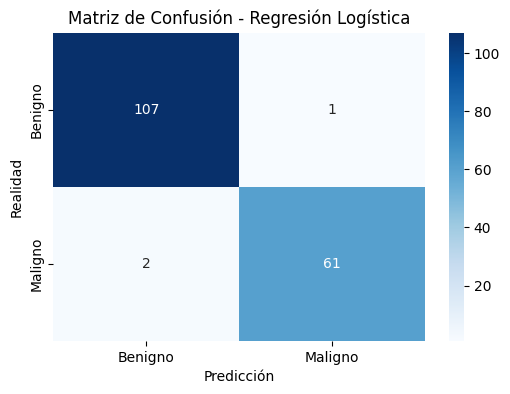

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la matriz de confusión para la regresión logística
conf_matrix_logit = confusion_matrix(y_test, y_pred_class_logit)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_logit, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
